# Priors, Likelihoods, Posteriors, and All That: Problems

## Problem 1: The Curse of Dimensionality; or why self driving cars are hard.

### 1a) Sampling in low dimensions

Generate a sample of 100 randomly distributed points inside a 2D square. 


In [1]:
import numpy as np 
import matplotlib.pyplot as plt

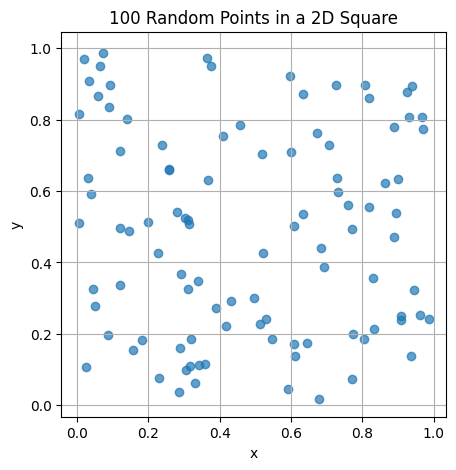

In [2]:
#1.a)
np.random.seed(42)
points_2d = np.random.uniform(0, 1, size=(100, 2))

plt.figure(figsize=(5, 5))
plt.scatter(points_2d[:, 0], points_2d[:, 1], alpha=0.7)
plt.xlabel("x")
plt.ylabel("y")
plt.title("100 Random Points in a 2D Square")
plt.grid(True)
plt.axis("square")
plt.show()


### 1b) Distances in low dimensions

Calculate the pairwise distances between all of the points, in d-dimensions, for two points x_i and y_i, this quantity is

$$ |x - y| = \sqrt{\Sigma (x_i - y_i)^2} $$


In [3]:
from scipy.spatial.distance import pdist, squareform

In [4]:
# 1.b)

distances = pdist(points_2d, metric='euclidean')

mean_dist = np.mean(distances)
std_dist = np.std(distances)

print(f"Mean pairwise distance: {mean_dist:.4f}")
print(f"Standard deviation: {std_dist:.4f}")

Mean pairwise distance: 0.5346
Standard deviation: 0.2524



### 1c) Distribution of distances in low dimensions 

Plot the distribution of these distances. Do you notice anything interesting? Is a "special value" picked out?


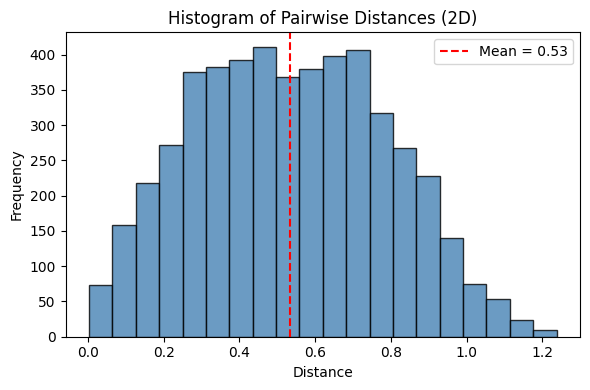

In [5]:
# 1.c)
plt.figure(figsize=(6, 4))
plt.hist(distances, bins=20, color='steelblue', edgecolor='black', alpha=0.8)
plt.axvline(mean_dist, color='red', linestyle='dashed', label=f'Mean = {mean_dist:.2f}')
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Histogram of Pairwise Distances (2D)")
plt.legend()
plt.tight_layout()
plt.show()


### 1d) Extending to d-dimensions

Now, let's consider the difference between picking a point located in a d-dimensional sphere vs in a d-dimensional cube. To do this, calculate and plot the the difference between the volume of a cube centered at the origin and going from [-1, 1] and the volume of a unit-radius sphere as the dimension d of the space increases. Possibly helpful formula: 

$$ Sphere: V_d = \frac{\pi^{d/2}}{\frac{d}{2} \Gamma(\frac{d}{2})} R^d$$ 

where R is the radius of the sphere.

$$ Cube: V_d = L^d $$

and L is the length of a side.


In [6]:
from scipy.special import gamma

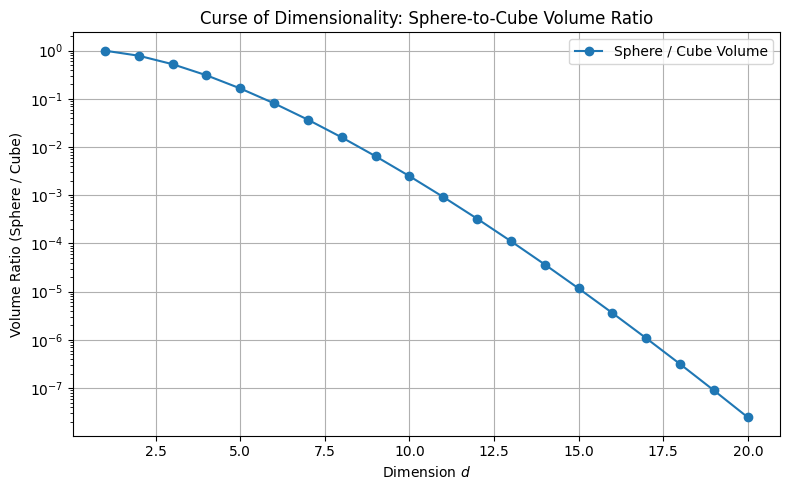

In [7]:
dimensions = np.arange(1, 21)

sphere_vol = np.array([np.pi**(d/2) / gamma(d/2 + 1) for d in dimensions])
cube_vol = np.array([2**d for d in dimensions])

volume_ratio = sphere_vol / cube_vol
volume_difference = cube_vol - sphere_vol

# Plot
plt.figure(figsize=(8, 5))
plt.plot(dimensions, volume_ratio, 'o-', label='Sphere / Cube Volume')
plt.yscale('log')
plt.xlabel("Dimension $d$")
plt.ylabel("Volume Ratio (Sphere / Cube)")
plt.title("Curse of Dimensionality: Sphere-to-Cube Volume Ratio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 1e) Sampling in d-dimensions

Now, consider the problem of sampling in high-dimensions. If we use a uniform prior on every parameter, our expectation is that we will well sample the parameter space simply by picking in a "uniform way". Calculate the ratio of volume contained in an annulus between $R$ and $R - \epsilon$ for d = 1-20 and plot this. Interpret your result in terms of a sampling problem. Are uniform priors a good choice in higher dimensions? Why or why not?

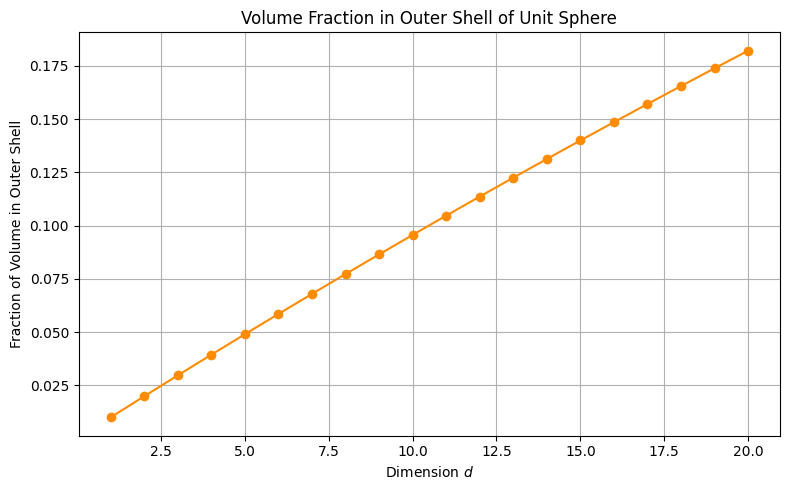

In [11]:
epsilon = 0.01
dimensions = np.arange(1, 21)

fraction_in_shell = 1 - (1 - epsilon)**dimensions

# Plot
plt.figure(figsize=(8, 5))
plt.plot(dimensions, fraction_in_shell, 'o-', color='darkorange')
plt.xlabel("Dimension $d$")
plt.ylabel("Fraction of Volume in Outer Shell")
plt.title("Volume Fraction in Outer Shell of Unit Sphere")
plt.grid(True)
plt.tight_layout()
plt.show()

**Uniform priors** are **NOT** a good choice in higher dimensions! Most of the volume lies in the outer shell/close to the edges of the shape/edge of dimensions. So the space is mostly empty in the center.

## Problem 2: Not everything is Gaussian

In the lecture and challenge problems, we've emphasized the importance of the Gaussian distribution. This distribution is very common, but not universal. In a (perhaps apocryphal story) this problem was given to first year students at Cambridge in the 1980s. It concerns estimating the distance to an off-shore lighthouse based on the timing of pulses. A canonical statement of the problem is, 

"A lighthouse is situated at unknown coordinates $x_0,y_0$ with respect to a straight coastline y=0. It sends a series of N flashes in random directions, and these are recorded on the coastline at positions $x_i$." 

### Problem 2-0) Draw the picture. 

With your partner, draw the picture.

In [9]:
from numpy.random import uniform 
import matplotlib.pyplot as plt

We drew the picture

### Problem 2a) Prior and Data Generation 

Write down a prior for the $x_0, y_0$ position of the lighthouse. Implement a python function that returns a uniform probability (or if you'd like, another prior) for $x_0, y_0$. Hint: It is easier to write the prior in terms of the angle $\theta$ between the line connecting the lighthouse to the shore and the direction in which the pulse is emitted. 

In order to produce a Bayesian estimate of the x-y position, we'll need some data. Generate ~$10^3$ datapoints.

In [22]:
# unknown true values of the position 

x_0 = 10
y_0  = 30

# generate data assuming a uniform prior 

thetas = np.random.uniform(-np.pi/2, np.pi/2, 1000) # you fill 

def make_data(theta):
    # function to return x positions at which pulses from the lighthouse are observed along the coast 
    x_i = np.zeros_like(theta)
    mask = theta >= 0
    x_i[mask] = x_0 + y_0 * np.tan(theta[mask])
    x_i[~mask] = x_0 - y_0 * np.tan(theta[~mask])
    return x_i

xs = make_data(thetas)

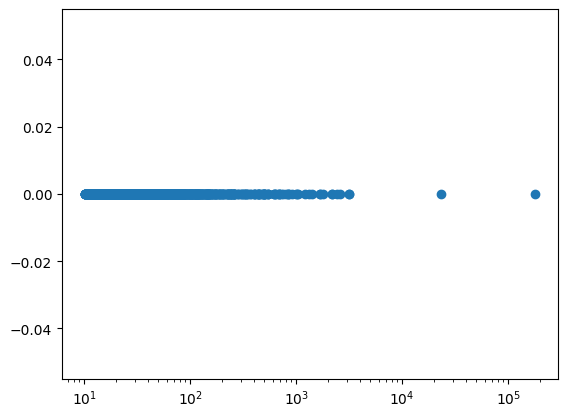

In [24]:
plt.scatter(xs, np.zeros(len(xs)))
plt.xscale('log')

### Problem 2b) Likelihood 

Now, we need to determine the form of the likelihood. If you have been following the hint in 2a), we want to turn a function of the data (shoreline positions, x) in terms of the angle ($\theta$). First, write down the relationship between the $x_0$ position of the lighthouse, the data x, and the angle ($\theta$). If you get stuck here, ask us and we will provide the likelihood. 

In [25]:
def lighthouse_likelihood(x, x0, y0):
    """
    Compute the likelihood p(x | x0, y0)
    Parameters
    ----------
    x : array_like
        Observed x positions on the shore
    x0 : float
        True x-position of the lighthouse
    y0 : float
        True y-position of the lighthouse (must be > 0)

    Returns
    -------
    likelihood : array_like
        Likelihood values p(x | x0, y0)
    """
    return (1 / np.pi) * (y0 / ((x - x0)**2 + y0**2))

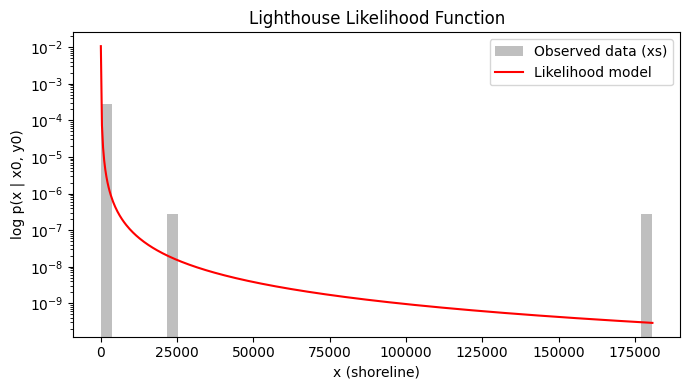

In [31]:
# Compute likelihoods for the observed shoreline hits
likelihoods = lighthouse_likelihood(xs, x_0, y_0)

# Optional: visualize how well the likelihood models the data
plt.figure(figsize=(7, 4))
plt.hist(xs, bins=50, density=True, alpha=0.5, label='Observed data (xs)', color='gray')
x_vals = np.linspace(min(xs), max(xs), 500)
plt.plot(x_vals, lighthouse_likelihood(x_vals, x_0, y_0), 'r-', label='Likelihood model')
plt.xlabel('x (shoreline)')
plt.ylabel('log p(x | x0, y0)')
# plt.xscale('log')
plt.yscale('log')
plt.title('Lighthouse Likelihood Function')
plt.legend()
plt.tight_layout()
plt.show()

### Problem 2c)

Using Bayes' theorem, write down the posterior. Implement a grid search function to calculate the posterior for the x-y position of the lighthouse. For now, you can assume that the posterior is equal to the likelihood. We will shortly (jargon) **regularize** the likelihood with a prior.

In [ ]:
def ln_posterior(x_0, y_0, x): #priors will go here):
    
    # add priors here after completing the next step first. 
    
    y_0 = np.abs(y_0) + 1e-10  # avoid divide-by-zero
    log_likelihood = # you fill
    return np.sum(log_likelihood)

x_0_grid = #you fill
y_0_grid = # you fill 

In [ ]:
def grid_search(x_0_grid, y_0_grid, x):
    M, B = np.meshgrid() 
    posterior_grid = np.zeros(M.shape)

    for #you fill:
        for #you fill:
            #you fill
    
    return posterior_grid

In [ ]:
log_posterior = 
# try renormalizing here if you have numerical issues. 
posterior = 

plt.imshow(posterior.T,
           extent=(x_0_grid[0], x_0_grid[-1], y_0_grid[0], y_0_grid[-1]),
           origin='lower',
           cmap='plasma')
plt.plot(x_0, y_0, label='Truth')
plt.colorbar(label='Posterior')
plt.xlabel('x_0')
plt.ylabel('y_0')
plt.legend()
plt.show()

### Problem 2d-2) Priors

Now consider the effect of a prior by implementing uniform priors. Does the quality of your fit change? What if you fit with fewer datapoints, say N=100 rather than N=1000?


### Problem 2e) [Optional] Challenge: Is your likelihood a Gaussian? What is special about your likelihood?

One property of a Gaussian that makes it "special" is that it is the maximum entropy distribution for for finite first and second moments. Calculate the first and second moments of your likelihood distribution. What makes this distribution special? Generate some example plots of your likelihood function and compare to a Gaussian distribution over the same range. Are these curves the same? What is different about them?

## Problem 3: The Hubble Tension and Measurement Inconsistency 

One of the most exciting topics in observational cosmology right now is the apparent inconsistency in measurements of the hubble constant from early and late times in the history of the universe. 

### Preliminaries - import some libraries

In [ ]:
import emcee
import corner

### Problem 3a) Generate two toy datasets with different values of the slope and intercept to play with:

In [ ]:
np.random.seed(11)

def model(m, b, x):
    return m*x + b

x = np.linspace(7, 12)
y = model(1.24, -10.09, x)
y2 = model(2, -9.5, x)

yerr = #make up some errors
data_y = y + #include scatter 

yerr2 = #make up some errors
data_y2 = y2 + #include scatter


# make a plot 

plt.xlabel('Mass ($M_{Sun}$)')
plt.ylabel('SFR ($M_{Sun} yr^{-1}$)')

### Problem 3b) Use the MAP estimate for the first line to initialize an emcee sampler

In [ ]:
pos = [1.28, -10.4] + 0.1*np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, data_y, yerr)
)

sampler.run_mcmc(pos, #how long should this run for 
                 , progress=True)

import corner
flat_samples = sampler.get_chain(#how many values should be discarded as "burn in", 
                                 thin=100, flat=True)


labels = ["m", "b"]

fig = corner.corner(
    flat_samples, labels=labels, truths=[1.24, -10.09], quantiles = [0.05, 0.5, 0.95]
)

### Problem 3c) Now fit the combination of both datasets

In [ ]:
# make total arrays that have the combined dataset 
# discusss with your neighbor how to do a joint fit of two datasets - should they be fit together
# or separately? 

pos = [1.28, -10.4] + 0.1*np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x_total, y_total, yerr_total)
)

sampler.run_mcmc(pos, #how many steps to run?
                 , progress=True)

flat_samples2 = sampler.get_chain(discard= #how many to discard
                                  , thin=100, flat=True)

labels = ["m", "b"]

fig = corner.corner(
    flat_samples2, labels=labels, truths=[1.24, -10.09], quantiles = [0.05, 0.5, 0.95]
)

## Problem 4: Measuring distances - when priors matter

A famous example where your choice of prior matters is found in parallax measurements. In this problem, we will explore this. 

(Thank you Adrian Price-Whelan for contributing this problem!) 

In [ ]:
# import statements

import astropy.units as u
import astropy.table as at
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# import arviz as az
from astroquery.gaia import Gaia
import pymc as pm

In [ ]:
# query Gaia 
# Cohort 5 students should confirm that they understand the database syntax here based on 
# the material from Session 15.
# Cohort 6 students - we will cover this in Session 21 : ) 

job = Gaia.launch_job(
    "SELECT TOP 1 * FROM gaiadr3.gaia_source WHERE parallax_over_error > 3 and parallax_over_error < 4"
)
data = at.QTable(job.get_results().filled())

In [ ]:
# print the data - make sure you understand its structure

# you fill 

In [ ]:
# now let's consider two choices of prior. First, a uniform prior, and then a truncated normal. 

def uniform_space_density_logp(L):
    def lpdf(r):
        return (2*pm.math.log(r)) - 3*pm.math.log(L) - pm.math.log(2) - r/L
    return lpdf

with pm.Model() as model:
    r = pm.DensityDist(
        'r', 
        logp=uniform_space_density_logp(4.), 
        initval=1.,
        transform=pm.distributions.transforms.LogTransform()
    )
    plx = pm.Normal(
        'plx',
        mu=1/r,
        sigma=data['parallax_error'][0].to_value(u.mas),
        observed=data['parallax'][0].to_value(u.mas)
    )
    
    samples_usd = pm.sample(tune=2000, draws=2000)

In [ ]:
with pm.Model() as model:
    r = pm.TruncatedNormal(
        'r', 
        mu=2.,
        sigma=1.,
        lower=0,
        initval=1.,
        transform=pm.distributions.transforms.LogTransform()
    )
    plx = pm.Normal(
        'plx',
        mu=1/r,
        sigma=data['parallax_error'][0].to_value(u.mas),
        observed=data['parallax'][0].to_value(u.mas)
    )
    
    samples_truncnorm = pm.sample(tune=2000, draws=2000)

In [ ]:
# And plot the results

# you fill 

## [Pen & Paper] Challenge Problem: The Gaussian Derivation of the Central Distribution

In the lecture, we see two derivations of the Central distribution based on physical arguments. The first, spatial homogeneity, arose to solve a problem in astronomy, while the second based on convolutions of distributions (and "additive physical processes" arose in condensed matter physics and electrical engineering. In this problem, we'll study another derivation that also arose in the fitting of the orbits of the planets. 

### Maximum Likelihood Estimates

Begin by reviewing the discussion in Adam's lecture yesterday of the "maximum likelihood estimate" of a parameter. Then, write a general expression for the maximum of the log-likelihood. Then re-express your MLE statmeent in terms of a function $g'(\hat{\theta} - x$), where $\hat{\theta}$ is your MLE estimate for the parameter $\theta$ and $g(\theta-x) = log f(x_i | \theta)$ is your log-likelihood.

### The arithmetic mean and roots of the MLE

Now assume that the MLE must be given by the arithmetic mean of the observations, 

$$ \hat{\theta} = \bar{x} = \frac{1}{n+1} \Sigma_{i=0}^n x_i $$ and consider a simple sample. This sample should have one observation $x_0 = (n+1)(\theta - x)$. Now compute $\hat{\theta}$ and $\hat{\theta} - x_0$. What is the value of $g'(\hat{\theta} - x$)? Is this symmetric or anti-symmetric?

### Functional equations

Given your expression for $g'(\hat{\theta} - x)$, do some functional analysis. What are the possible functional forms of $g(u)$? Then plug them into your original MLE expression. You will find that 

$$ f(x|\theta) = \sqrt{\frac{\alpha}{2\pi}} \exp \left[ -  \frac{1}{2} \alpha (x-\theta)^2 \right]$$

As noted in the lecture, the historical importance of this result is that the assumption that $\hat{\theta} = \bar{x}$ provides a theoretical basis for the intuitive notion that errors cancel. This put to rest a long running argument about the nature of additive errors and justifies much of what we assume as a matter of course.